In [47]:
import numpy as np
random = np.random.default_rng(42)
import seaborn as sns
from tqdm import tqdm
# Szimbad-problem: Renyi Alfred - Krúdy Gyula

# environmnet

_n_ = 6
_min_sympathy = 0
_max_sympathy = 30

# state: (i, value)
# G: expected reward

In [48]:
from collections import namedtuple
from enum import Enum

_action_ = Enum('Action', 'next choose')

Environment = namedtuple('Environment', 'candidates i chosen')
State = namedtuple('State', 'candidate i chosen')

# the full environment
def init_environment():
    return Environment(random.integers(_min_sympathy, _max_sympathy, _n_), 0, False)

# what Simbad knows (Simbad has no memory, for now)
def env2state(env):
    return State(env.candidates[env.i], env.i, env.chosen)


def update_env(env, action):
    if action == _action_.next:
        return Environment(env.candidates, env.i+1, False)  # next please
    else:
        return Environment(env.candidates, env.i, True)  # flag the chosen one


def render_environment(env):
    cursor = np.repeat(' ', len(env.candidates))
    if env.chosen:
        cursor[env.i] = 'X'
    else:
        cursor[env.i] = '|'

    print(' '.join(cursor))
    print(' '.join(env.candidates.astype(str)))

In [49]:
render_environment(update_env(init_environment(), _action_.next))


  |        
2 23 19 13 12 25


In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

# calculate the softmax of a vector
def softmax(vector):
 e = np.exp(vector)
 return e / e.sum()

# agent: Sinbad
#Defining the different parameters
_epsilon_ = 0.2
_alpha_ = 0.1 # learning rate
_gamma_ = 0.6 # temporal discount factor
 
#Initializing the Q-matrix

def init_simbad():
             # candidates   action space
    #return np.full((_max_sympathy - _min_sympathy, _n_, len(_action_)), 0.0) 
    return random.normal(0, 0.001, (_max_sympathy - _min_sympathy, _n_, len(_action_))) 

def get_Q(state, action):
    return Q[state.candidate, state.i, action.value-1]

def set_Q(state, action, q):
    Q[state.candidate, state.i, action.value-1] = q
    
def get_best_Q(state):
    return _action_(np.argmax(Q[state.candidate, state.i, :])+1)

def plot_Q(Q, kind='dual'):
    #toplot = Q[:, :, 1] - Q[:, :, 0] # next - choose
    #sns.heatmap(np.sign(toplot[:, :]), center=0)
    #plt.show()
    
    if kind=='dual':
        sns.heatmap(Q[:, :, 0], annot=True, center=0)
        plt.show()
        sns.heatmap(Q[:, :, 1], annot=True, center=0)
        plt.show()
    elif kind == 'sign':
        toplot = Q[:, :, 1] - Q[:, :, 0] # choose - next
        toplot[:, -1] = np.nan
        sns.heatmap(np.sign(toplot[:, :]), center=0, cmap='coolwarm', vmin=-2, vmax=2)
        plt.show()
    elif kind == 'softmax':
        sns.heatmap(np.apply_along_axis(softmax, 2, Q)[:, :, 1], center=0.5, annot=False, cmap='coolwarm', vmin=0, vmax=1)
        plt.show()
    else:
        toplot = Q[:, :, 1] - Q[:, :, 0] # choose - next
        toplot[:, -1] = np.nan
        sns.heatmap((toplot[:, :]), center=0, cmap='coolwarm', annot=False)
        plt.show()

def simbad_choose_action(state):
    action=0
    if state.i == _n_-1: # must choose the last one
        return _action_.choose
    
    if state.chosen:
        return _action_.choose # already chosen
    
    if random.uniform(0, 1) < _epsilon_: # random decision
        action = random.choice(_action_)
    else:
        action = get_best_Q(state)
    return action

def simbad_get_reward(state, action):
    if action == _action_.next:
        return 0
    else:
        return state.candidate - (_max_sympathy - _min_sympathy) / 2
 
# Function to learn the Q-value
def simbad_update(state, state2, reward, action):
    predict = get_Q(state, action)
    target = reward + _gamma_ * np.max([get_Q(state2, _action_.next), get_Q(state2, _action_.choose)])
        # prediction    #learning rate   #prediction error
    q2 = predict + _alpha_ * (target - predict)
    
    #print('* Update:', state, action)
    #print('Target: reward + _gamma_ * get_Q(state2, action2)')
    #print('Target:', reward, '+', _gamma_, '*', get_Q(state2, action2), '=', reward + _gamma_ * get_Q(state2, action2))
    #print('Q: predict -> predict + _alpha_ * (target - predict)')
    #print('Q:', predict, '->', predict, '+', _alpha_, '*', (target - predict), '=', q2)
    
    set_Q(state, action, q2)
   
##############################

_simbad_memory_ = []

MemEntry = namedtuple('MemEntry', 'state action state2 reward')

def simbad_memorize(state, action, state2, reward):
    _simbad_memory_.append(MemEntry(state, action, state2, reward))

    
def simbad_planning(n):
    for i in range(n):
        mem = MemEntry(*random.choice(_simbad_memory_))
        action = random.choice(_action_) # random action
        reward = simbad_get_reward(mem.state, action)
        if action == _action_.next:
            state2 = mem.state2 
        else:
            state2 = mem.state
        simbad_update(mem.state, state2, reward, action)
        



  0%|          | 0/1000 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:102: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

100%|██████████| 1000/1000 [00:09<00:00, 109.59it/s]


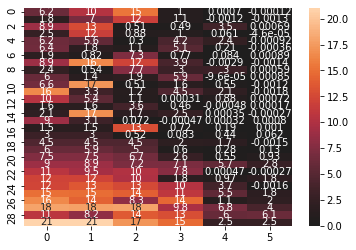

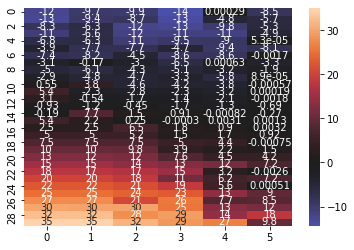

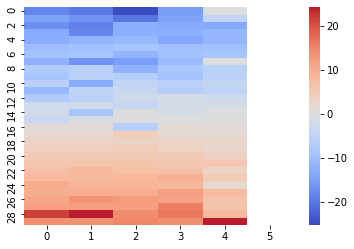

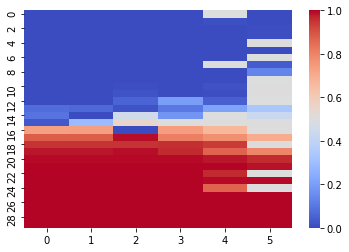

In [95]:
random = np.random.default_rng(2025)

_total_episodes_ = 1000
_n_planning_ = 50

# init simbad
Q = init_simbad()
_simbad_memory_ = []

choice = []

for episode in tqdm(range(_total_episodes_)):
    env = init_environment()
    _simbad_memory_ = []
    
    action = simbad_choose_action(env2state(env))
    #print(action)
    #render_environment(env)

    for i in range(_n_):
        #Getting the next state
        env2 = update_env(env, action)
 
        #Choosing the next action
        action2 = simbad_choose_action(env2state(env2))
        
        # getting reward for this next state
        reward = simbad_get_reward(env2state(env), action)
        
        if env.chosen:
            break
        
        #print('r', reward, action)
         
        #Learning the Q-value
        simbad_update(env2state(env), env2state(env2), reward, action)
        #plot_Q(Q) 
        
        simbad_memorize(env2state(env), action, env2state(env2), reward)
        simbad_planning(_n_planning_)

        env = env2
        action = action2
        #render_environment(env)
        
    choice.append(reward)
         
plot_Q(Q, kind='dual') 
plot_Q(Q, kind='diff') 
plot_Q(Q, kind='softmax') 

In [96]:
import plotly.express as px

import pandas as pd
df = pd.DataFrame({
    'x': np.arange(_total_episodes_),
    'y': np.array(choice) + (_max_sympathy - _min_sympathy) / 2
})

fig = px.scatter(df, x="x", y="y", trendline="lowess")
fig.update_traces(marker=dict(size=1,
                              opacity=500/_total_episodes_,
                              line=dict(width=4,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.data = [t for t in fig.data if t.mode == "lines"]
fig.show()

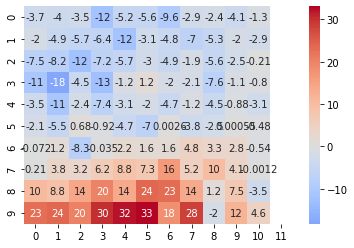

In [436]:
    #toplot = Q[:, :, 1] - Q[:, :, 0] # choose - next
    #sns.heatmap(np.sign(toplot[:, :]), center=0, annot=True)
    #plt.show()
    
    toplot = Q[:, :, 1] - Q[:, :, 0] # choose - next
    toplot[:, -1] = np.nan
    #mean = toplot.mean(axis=0,keepdims=1)
    #std = toplot.std(axis=0,keepdims=1); 
    #toplot = (toplot-mean)/std
    sns.heatmap((toplot[:, :]), center=0, annot=True, cmap='coolwarm')
    plt.show()
    
    #toplot = Q[:, :, 1] / Q[:, :, 0] # choose / next
    #toplot[:, -1] = np.nan
    #sns.heatmap((toplot[:, :]), center=0, annot=True)
    #plt.show()

In [134]:
# G_state = G_state + α(target — G_state)

<AxesSubplot:xlabel='x', ylabel='y'>

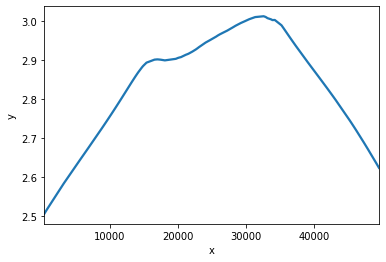

In [157]:
sns.regplot(data=df.sample(100), x='x', y='y', scatter_kws={'alpha':100/1000, 'color':'black'}, 
            lowess=True, scatter=False)

In [23]:
MemEntry(*random.choice(_simbad_memory_))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


MemEntry(state=State(candidate=3, i=0, chosen=False), action=<Action.next: 1>, state2=State(candidate=29, i=1, chosen=False), reward=0)